[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scryptan/python_hw/blob/master/First_hw_OOP.ipynb)

In [2]:
!pip install grequests
!pip install requests
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [3]:
import seaborn as sns
import grequests
import requests

from datetime import datetime
from IPython.display import clear_output

import pandas as pd
import matplotlib.pyplot as plt

import os
import os.path
import json
import warnings
warnings.simplefilter("ignore", category=UserWarning)

# Собираем список id всех объектов

In [5]:
class DomIdLoader:
    def __init__(self):
        self.offset_ = 1
        self.limit_ = 100
        self.url = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object'
        self.objects_data = []
        self.id_hundreds_count = 110

    def get_ids(self):
        async_requests = [grequests.get(f'{self.url}?offset={self.offset_ * i * self.limit_}&limit={self.limit_}') for i in range(self.id_hundreds_count)]
        
        for res in grequests.imap(async_requests, size=16):
            if not res.ok:
                continue

            objects_data = res.json()
            objects_list = objects_data.get('data').get('list')
            if not objects_list:
                continue

            self.objects_data.extend(x.get('objId') for x in objects_list)


    def show_ids(self):
        print(self.objects_data[:5])

In [6]:
%%time
loader = DomIdLoader()
loader.show_ids()
loader.get_ids()
loader.show_ids()

[]
[7, 8, 9, 10, 11]
CPU times: total: 2.34 s
Wall time: 26.7 s


# Собираем все возможные объекты по полученным прежде id

In [15]:
class ObjectInfoExtractor:
    def __init__(self, ids):
        self.ids_to_load = ids
        self.object_url = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/'
        self.full_objects = []
        self.last_df = None

    def load_actual_data(self):
        async_requests = [grequests.get(f'{self.object_url}{obj_id}') for obj_id in self.ids_to_load]
        
        for res in grequests.imap(async_requests, size=16):
            if not res.ok:
                continue

            object_data = res.json()
            full_obj = object_data.get('data')

            if not full_obj:
                continue

            clear_output()
            self.full_objects.append(full_obj)
            print()
            print(f'{len(self.full_objects)}/{len(self.ids_to_load)}')

    def get_from_github(self):
        return pd.read_pickle('https://raw.githubusercontent.com/scryptan/python_hw/master/output/output.pkl',compression={'method': 'bz2'})
#         return pd.read_csv('https://raw.githubusercontent.com/scryptan/python_hw/master/output/output.csv')
        
    def from_actual_df_converter(self):
        self.last_df = pd.json_normalize(self.full_objects)
        return self.last_df.copy()
          
        

In [10]:
extractor = ObjectInfoExtractor(loader.objects_data)
extractor.df_converter().shape
extractor.load_actual_data()
extractor.df_converter().shape

In [31]:
extractor.last_df.head()

,id,pdId,region,address,floorMin,floorMax,objElemLivingCnt,objReady100PercDt,wallMaterialShortDesc,objLkFinishTypeDesc,...,nameObj,transportDistIndex,transportDistIndexValue,airQualityIndexValue,complexShortNm,greenAreaIndexValue,developer.bankruptStage.bankruptStageCd,developer.bankruptStage.bankruptStageDesc,developer.bankruptStage.bankruptLawUrl,developer.orgBankruptMsgDttm
0,1867,2794,44,"г Кострома, поселок Волжский, д. 31 по ГП",2.0,2.0,4.0,2019-05-24,Блоки,Под чистовую,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1856,2160,23,"г Сочи, улица Старошоссейная, д. 5, корпус 6",14.0,14.0,328.0,2019-02-12,Монолит-кирпич,Под чистовую,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1854,2160,23,"г Сочи, улица Старошоссейная, д. 5, корпус 7",14.0,14.0,318.0,2020-03-23,Монолит-кирпич,Под чистовую,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1859,2160,23,"г Сочи, улица Старошоссейная, д. 5, корпус 10",14.0,14.0,334.0,2024-09-30,Монолит-кирпич,Под чистовую,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1853,2160,23,"г Сочи, улица Старошоссейная, д. 5, корпус 8",14.0,14.0,318.0,2022-02-07,Монолит-кирпич,Под чистовую,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Сохраним результаты на диск

In [8]:
class Saver:
    def __init__(self, df):
        self.df = df
        self.work_dir = f'{os.getcwd()}/output'
        if not os.path.exists(self.work_dir):
            os.makedirs(self.work_dir, exist_ok=True)

    def save_csv(self):
        self.df.to_csv(f'{self.work_dir}/output.csv')  

    def save_pkl(self):
        self.df.to_pickle(f'{self.work_dir}/output.pkl',compression={'method': 'bz2'})  

In [ ]:
%%time
df = extractor.get_from_github()
saver = Saver(df)
saver.save_csv()
saver.save_pkl()

# Подготовим данные для визуализации

In [17]:
regions = requests.get('https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/dictionary/regions').json()
regions_dict = dict((region['id'], region['name']) for region in regions)
df = extractor.get_from_github()

In [18]:
df.head(2)

,Unnamed: 0,id,pdId,region,address,nameObj,floorMin,floorMax,objElemLivingCnt,objReady100PercDt,...,developer.orgBankruptMsgDttm,airQualityIndexValue,metro.id,metro.name,metro.line,metro.color,metro.time,metro.isWalk,metro.colors,complexShortNm
0,0,47958,634257,1,"г Майкоп, Степная, литера 2",Жк Яблоневый эко район,7.0,10.0,225,2024-12-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,40103,449845,18,"г Ижевск, ул Фруктовая","Коммерческое обозначение объекта:Микрорайон""Но...",1.0,17.0,362,2024-03-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
regions_dict

{1: 'Республика Адыгея',
 2: 'Республика Башкортостан',
 3: 'Республика Бурятия',
 4: 'Республика Алтай',
 5: 'Республика Дагестан',
 6: 'Республика Ингушетия',
 7: 'Кабардино-Балкарская Республика',
 8: 'Республика Калмыкия',
 9: 'Карачаево-Черкесская Республика',
 10: 'Республика Карелия',
 11: 'Республика Коми',
 12: 'Республика Марий Эл',
 13: 'Республика Мордовия',
 14: 'Республика Саха (Якутия)',
 15: 'Республика Северная Осетия',
 16: 'Республика Татарстан',
 17: 'Республика Тыва',
 18: 'Удмуртская Республика',
 19: 'Республика Хакасия',
 20: 'Чеченская Республика',
 21: 'Чувашская Республика',
 22: 'Алтайский край',
 23: 'Краснодарский край',
 24: 'Красноярский край',
 25: 'Приморский край',
 26: 'Ставропольский край',
 27: 'Хабаровский край',
 28: 'Амурская область',
 29: 'Архангельская область',
 30: 'Астраханская область',
 31: 'Белгородская область',
 32: 'Брянская область',
 33: 'Владимирская область',
 34: 'Волгоградская область',
 35: 'Вологодская область',
 36: 'Воронеж

#  Рассчитать средние цены за квадратный метр по регионам.

In [1]:
class Visualizer:
    def __init__(self, data, options):
        self.data = data
        self.__options = options

    def make_barplot(self, x, y, hue = None):
        sns.set_theme()
        sns.set(rc = self.__options)
        sns.barplot(x = x, y = y, hue = hue, data = self.data, errorbar=None)


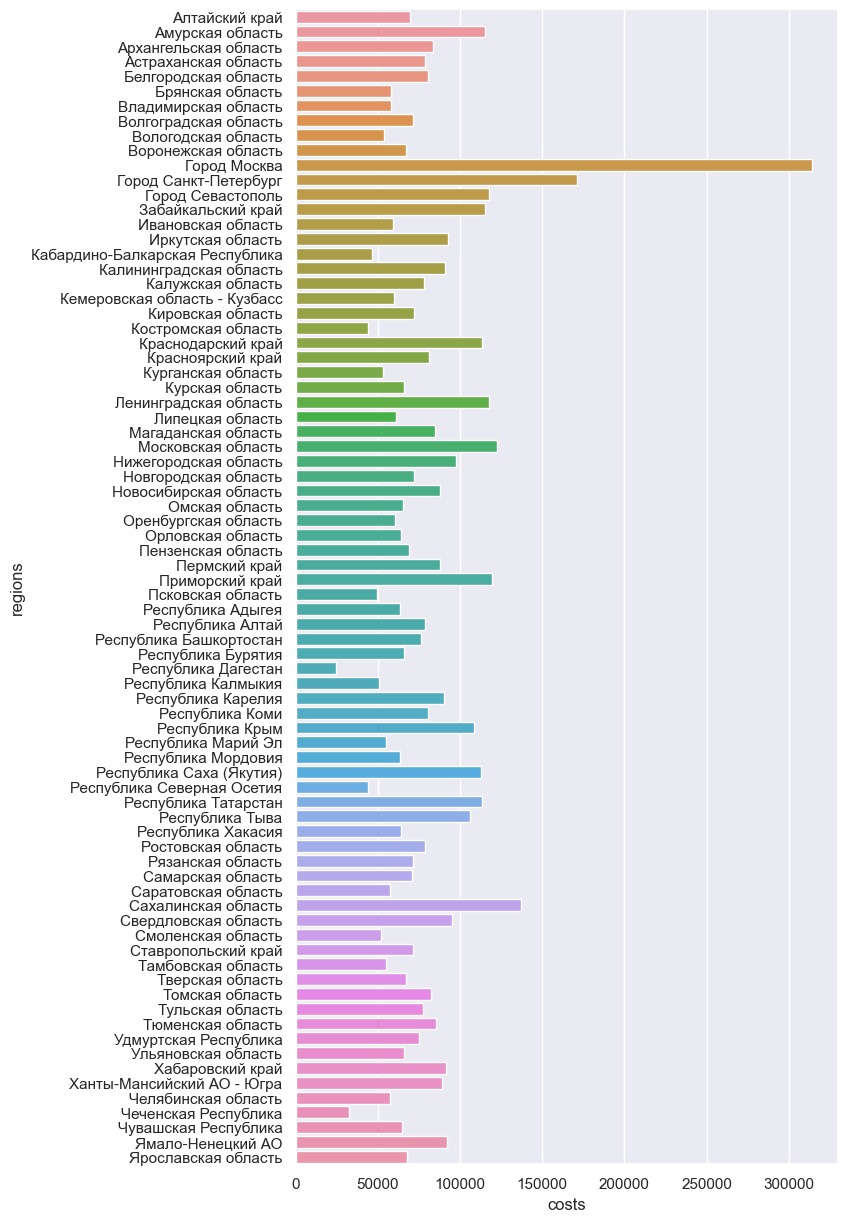

In [19]:
df_for_price = df.copy().dropna(subset=['objPriceAvg'])
pd.set_option('display.max_columns', None)
mean_prices_by_region = df_for_price.replace({"region": regions_dict}).groupby(['region'])['objPriceAvg'].mean()

prices_df = mean_prices_by_region.reset_index()
prices_df.columns = ['regions', 'costs']

prices_vis = Visualizer(prices_df,{'figure.figsize':(7,15)})
prices_vis.make_barplot('costs', 'regions')

Исходя из графика выше получается, что в МСК самая большая цена за квадратный метр, самая низкая в дагестане, большинство остальных менее 150000

# Вводимые по региону и году

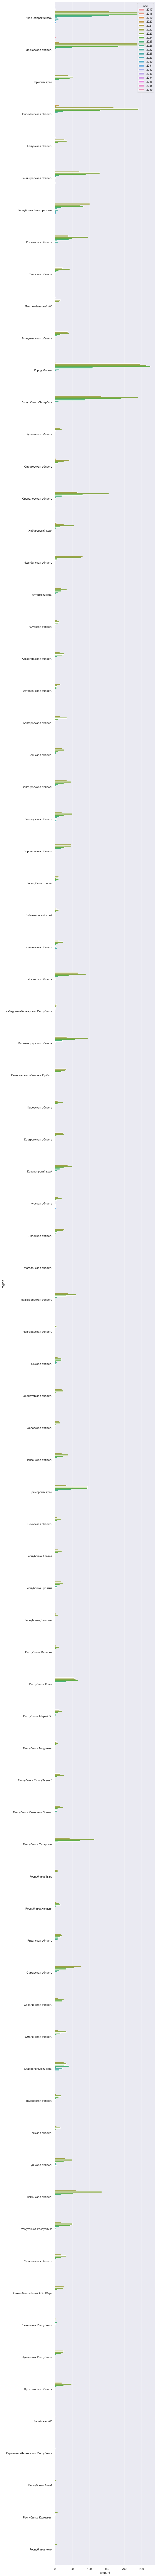

In [21]:
df_region_year = df.copy().replace({"region": regions_dict})

df_region_year['objReady100PercDt'] = pd.to_datetime(df_region_year['objReady100PercDt']).dt.year
df_region_year = df_region_year.rename(columns={'objReady100PercDt':'year', 'id':'amount'})

df_res = df_region_year.groupby(['year', 'region']).count().reset_index()


reigons_vis = Visualizer(df_res, {'figure.figsize':(7,180)})
reigons_vis.make_barplot('amount', 'region', 'year')

Из графика выше стало ясно, что большинство квартир будут сданы в районе 24 +- 2 года, так же большинство объектов будет сдано в москве, московской области, краснодарским краем, новосибирской областью и т.д

# Сравнить этажность домов, количество квартир, жилую площадь, количество парковочных мест и цену за квадратный метр в разных регионах

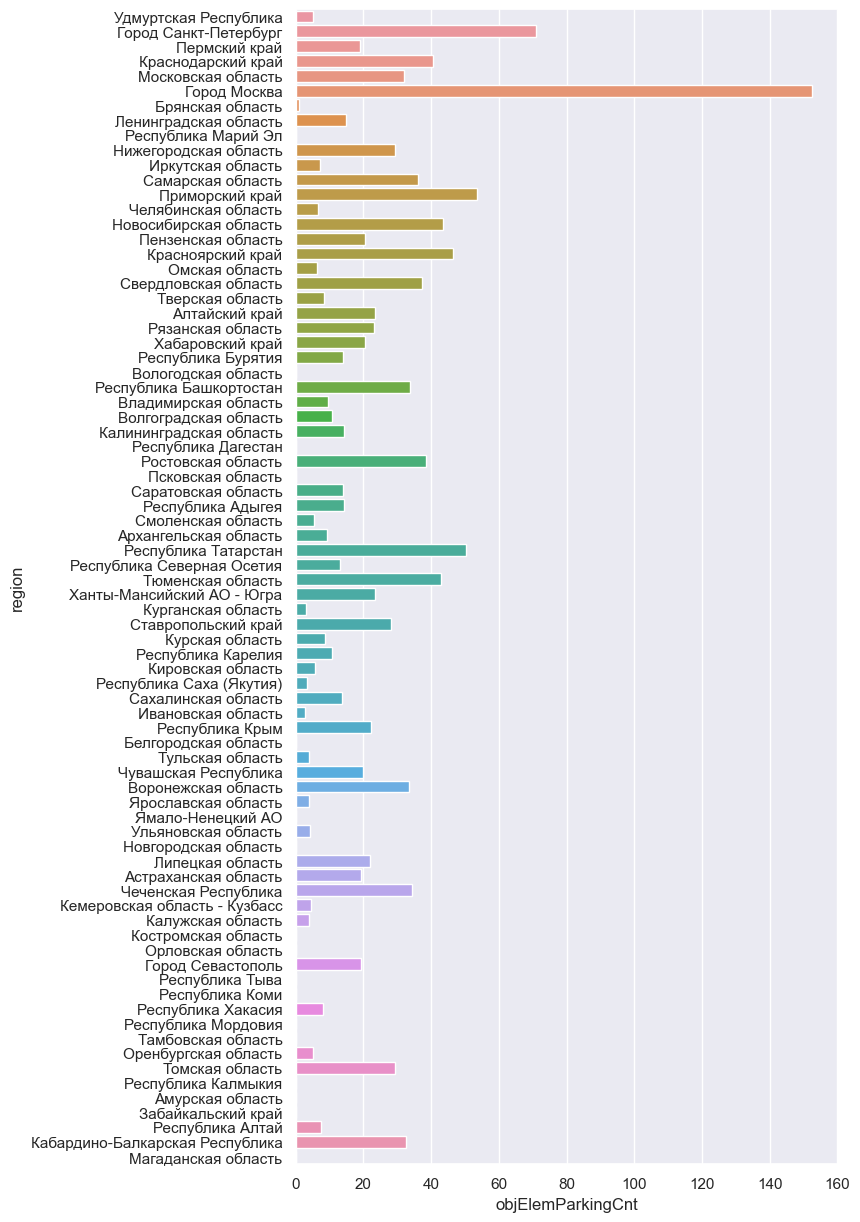

In [24]:
# objPriceAvg - цена за квадратный метр
# objSquareLiving - жилая площадь
# objFloorCnt - количество этажей
# objFlatCnt - количество квартир
# objElemParkingCnt - количество парковочных мест

df_region = df.copy().replace({"region": regions_dict})
df_region = df_region.dropna(subset=['objPriceAvg','objSquareLiving','objFloorCnt','objFlatCnt'])
df_region = df_region[['region', 'objPriceAvg','objSquareLiving','objFloorCnt','objFlatCnt', 'objElemParkingCnt']]

complex_vis = Visualizer(df_region, {'figure.figsize':(7,15)})
complex_vis.make_barplot('objElemParkingCnt', 'region')

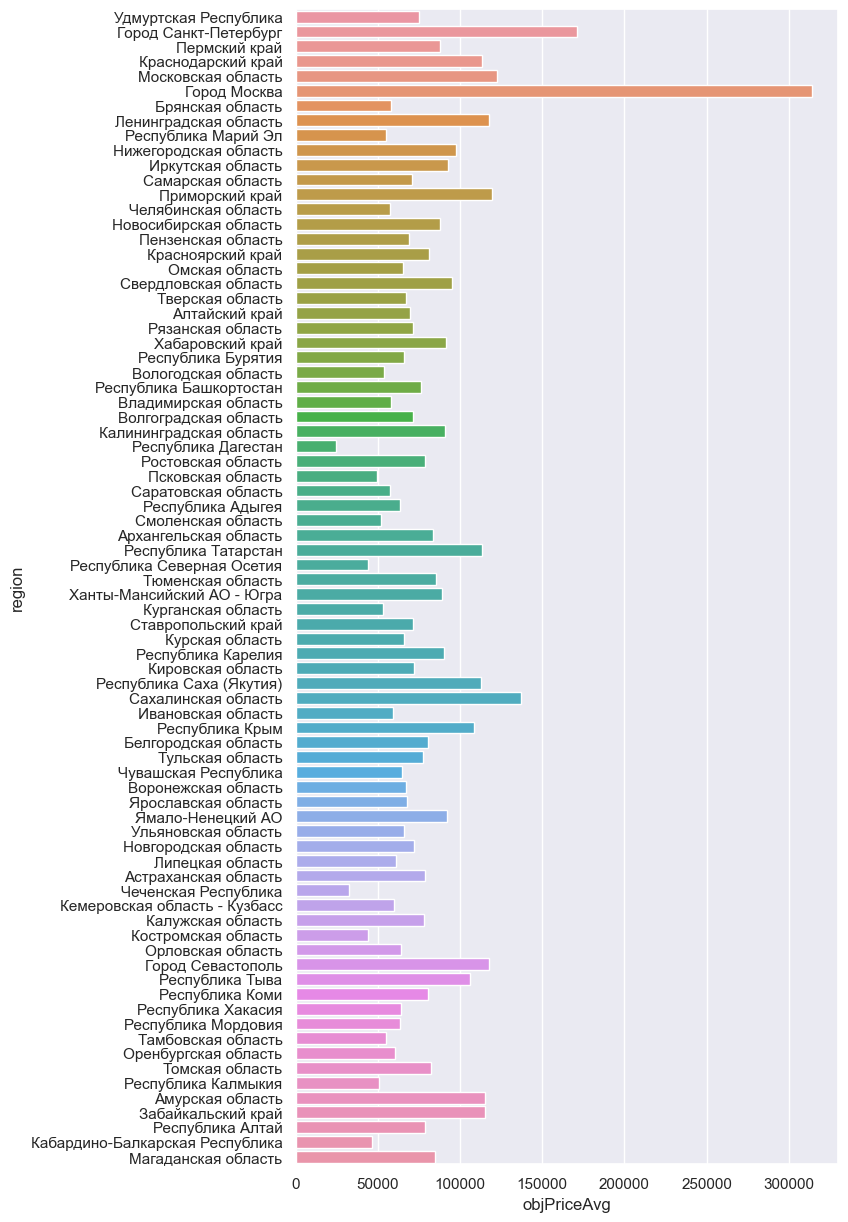

In [25]:
complex_vis.make_barplot('objPriceAvg', 'region')

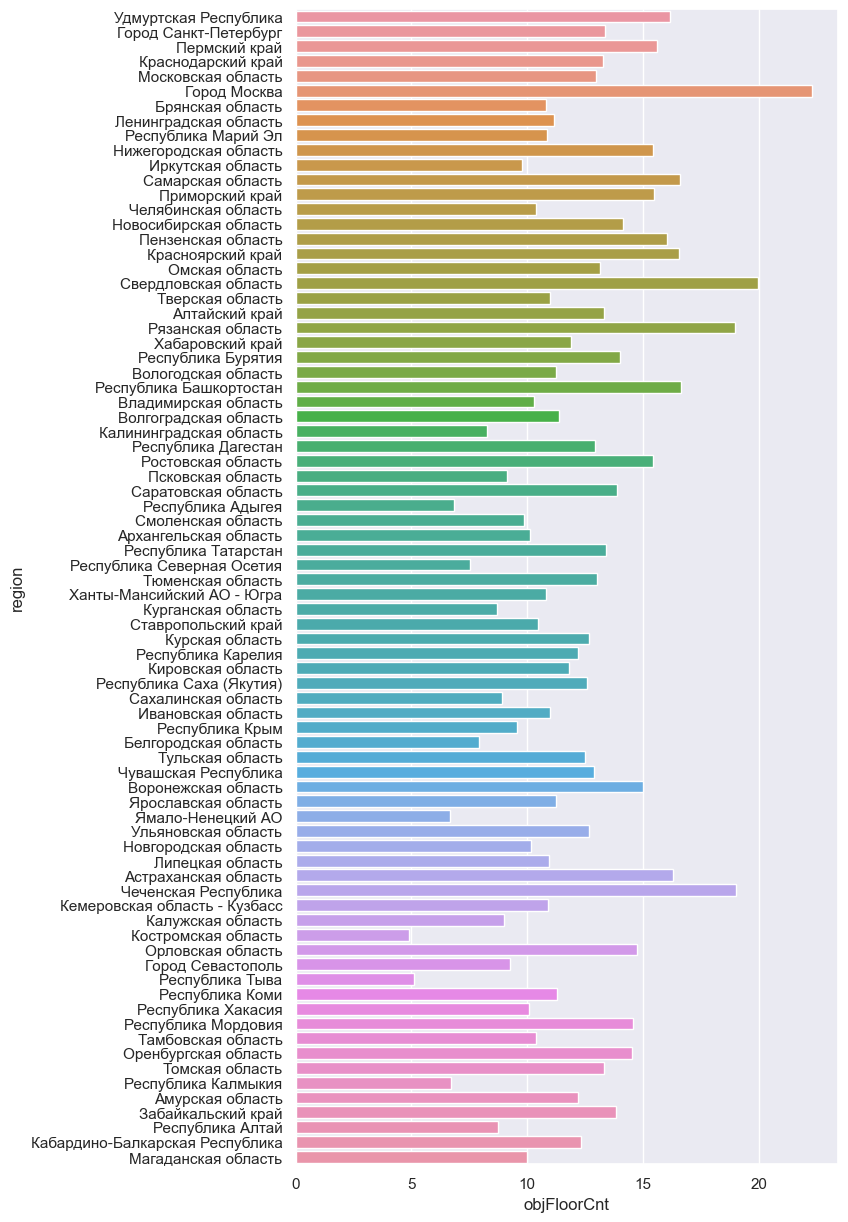

In [26]:
complex_vis.make_barplot('objFloorCnt', 'region')

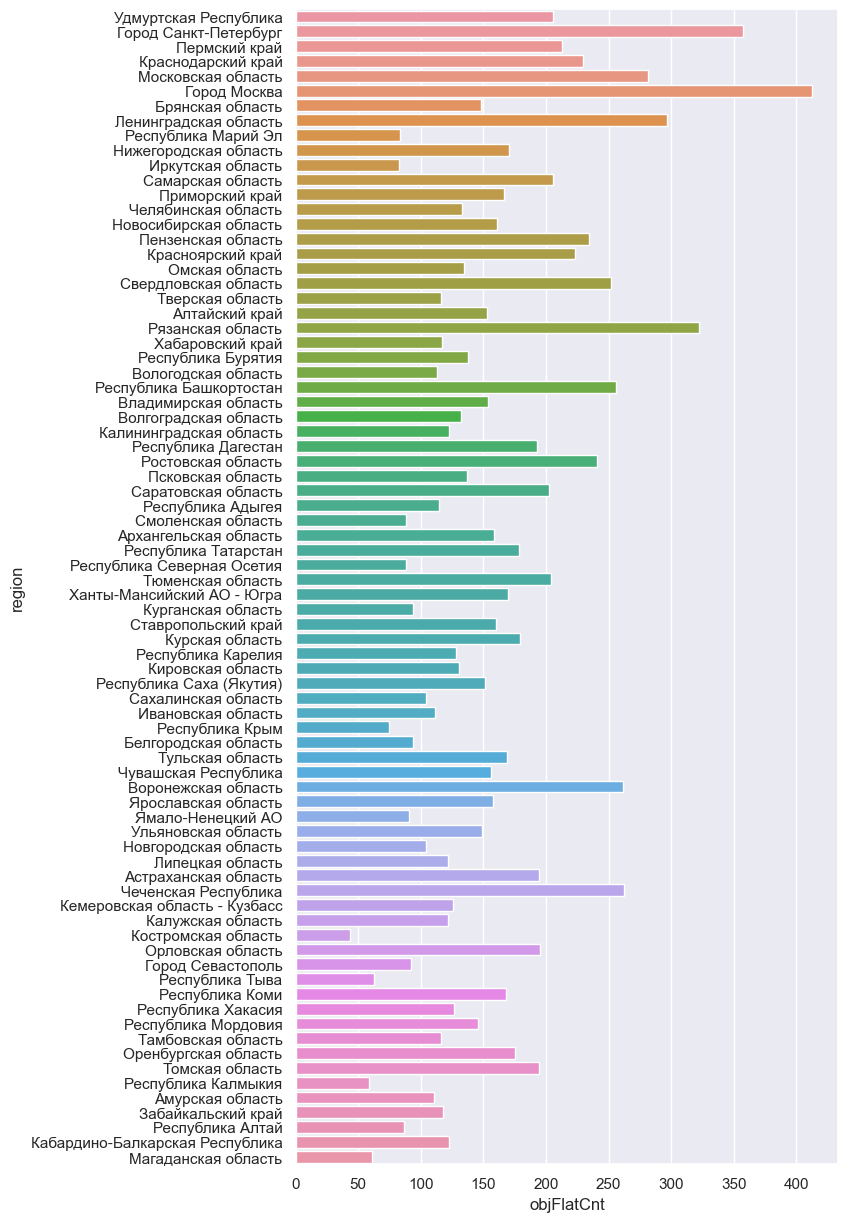

In [27]:
complex_vis.make_barplot('objFlatCnt', 'region')

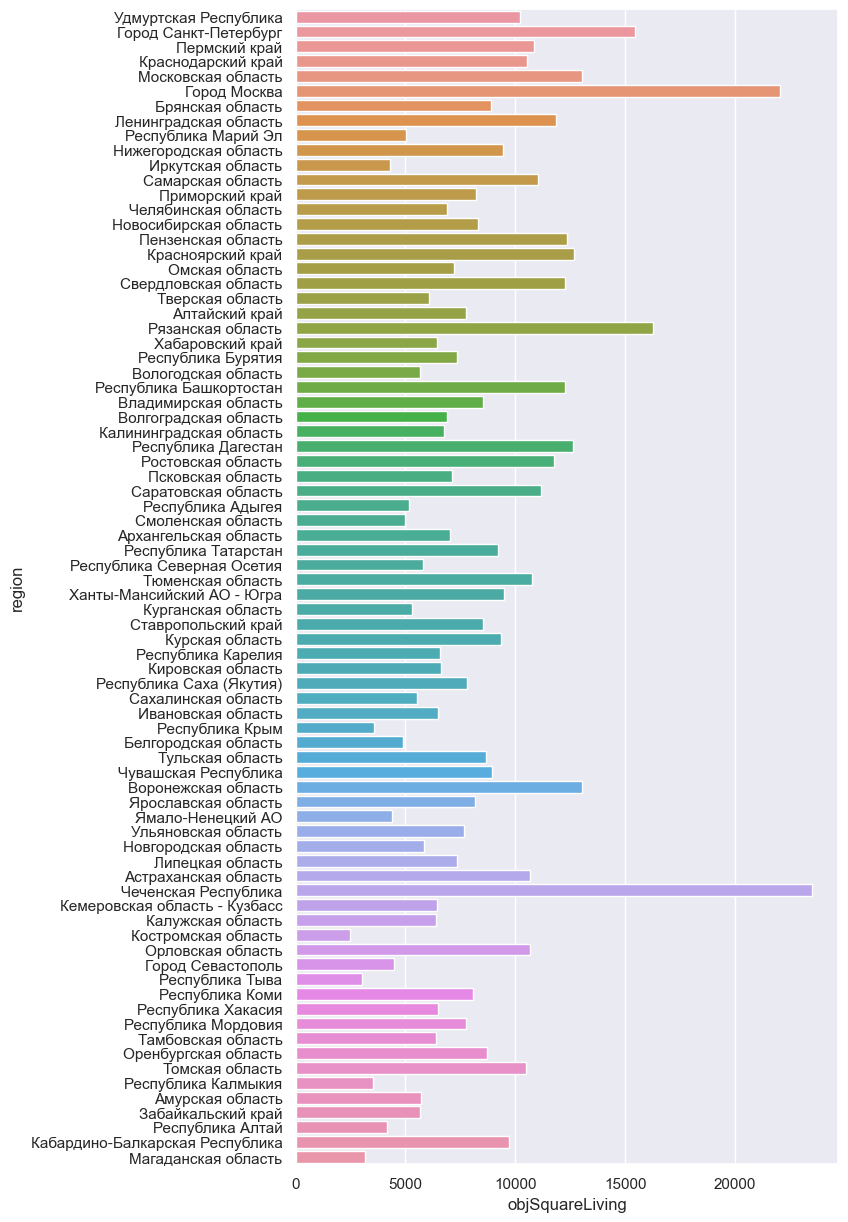

In [28]:
complex_vis.make_barplot('objSquareLiving', 'region')

Наибольшее количество парковок в москве, так же примерно в 20% регионов будут сданы объекты без парковочных мест
Наибольшие цены за квадратный метр в москве, спб, сахалинской области, наименьшие в дагестане, в остальном не привышают 150000
Наибольшая жилая площадь в чеченской республике, москве и рязанской республике, в остальном не превышают 15000
Наиболее высокие здания будут сданы в москве - 23 этаже, наименее высокие в костроме, до 5 этажей
Наибольшее количество квартир в москве, спб, рязанской области